# Download Dataset in Colab Directory da Google Drive.

In [0]:
# 0. Install libreria PyDrive.
!pip install -U -q PyDrive

In [0]:
# 1. Import librerie utili per il download del dataset.
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# 2. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
files = ['1-atujq8TbqZrvQmcIiUyNgmE-BI3k4ZU', '1iJhDDVjdgomhBwRIE59B-vOlu55yVFoN', '1PSqB87Y-pMA8q0uz0T-ETBOu1TrRo8-6',
        '1XdtKojN4_EYAbjTkUxfm4Y3wxhe74sGx', '1Wx-sL7hweoha2VIAEaxXQXCPMbSDR3hC', '1iGB6SksruGiKisUH7vxUrjCkB4Vn9cYt',
        '1CY9U9PECxbVFuczT4WJq6vtHOpicuF9-']

# 3. Choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('../home/Dataset')
try:
  os.makedirs(local_download_path)
except: pass

# 4. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
for folder in files:
  file_list = drive.ListFile(
      {'q': "'" + folder + "' in parents"}).GetList()

  for f in file_list:
# 5. Create & download by id.
    print('title: %s, id: %s' % (f['title'], f['id']))
    fname = os.path.join(local_download_path, f['title'])
    print('downloading to {}'.format(fname))
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)

title: RW9.mat, id: 1pWRx1RIqx9mT1k74e1CSGNEHT43FmzEs
downloading to ../home/Dataset/RW9.mat
title: RW12.mat, id: 1Cr8lTPRJaFdC6uMW0Ht3FyrXYA3o871T
downloading to ../home/Dataset/RW12.mat
title: RW11.mat, id: 1R5u8YD-1y8V3vGHu2s-Y7NqOjkCu5snf
downloading to ../home/Dataset/RW11.mat
title: RW10.mat, id: 1p7tfjhcC4Tx_qRyXA9J7AMT-uYFEiIPn
downloading to ../home/Dataset/RW10.mat
title: RW6.mat, id: 105xQZNRdWOjuaTd6nt_jyj5kTJYZEE59
downloading to ../home/Dataset/RW6.mat
title: RW5.mat, id: 1OckmnFPia-Y3UWqk3wkVbk_LyrbNfc_2
downloading to ../home/Dataset/RW5.mat
title: RW4.mat, id: 1Vr7gMzCQ-KkSOZQgXrCeDTHHWuumMtdp
downloading to ../home/Dataset/RW4.mat
title: RW3.mat, id: 1GwBJqQvg1-CjZAO8hXXapCvY2cr-Amsg
downloading to ../home/Dataset/RW3.mat
title: RW8.mat, id: 1NmBAq527dpyz-glmbrp_NzBcOo6NcWMD
downloading to ../home/Dataset/RW8.mat
title: RW7.mat, id: 1PfkVcHUaiLQvTrhKOpQQHgAwJyXnzXk9
downloading to ../home/Dataset/RW7.mat
title: RW2.mat, id: 15XBrFUGuP2dX5NFU1fdoBg8wcV8otzO4
downloadin

In [0]:
# 6. Cambio directory e verifica contenuti scaricati.
import os
os.chdir("..")
os.listdir("./")
os.chdir("home")
os.chdir("Dataset")
os.listdir("./")

['RW9.mat',
 'RW10.mat',
 'prediction.csv',
 'RW3.mat',
 'RW25.mat',
 'saved_models',
 'RW13.mat',
 'final_loss.png',
 'RW18.mat',
 'RW20.mat',
 'RW19.mat',
 'RW28.mat',
 'RW7.mat',
 'RW15.mat',
 'RW14.mat',
 'RW6.mat',
 'RW21.mat',
 'RW4.mat',
 'RW5.mat',
 'RW22.mat',
 'RW26.mat',
 'RW12.mat',
 'RW27.mat',
 'RW2.mat',
 'model.json',
 'RW11.mat',
 'RW8.mat',
 'RW24.mat',
 'RW1.mat',
 'RW23.mat',
 'RW16.mat',
 'RW17.mat']

# Data Pre-Processing.

In [0]:
# 0. Import delle librerie utili per il data pre-processing.
import pandas as pd
import scipy.io as scio
import numpy as np
from sklearn.utils import shuffle

In [0]:
# 1. Funzione per calcolare la capacità residua di ogni singolo step.
def compute_capacity(data):
  capacity_vector = [];
  
  for item in data:
    
    # 1.1. Se è uno step di reference discharge, calcola la capacità residua dello step.
    if(item[0][0] == 'reference discharge'):
      capacity_vector.append(np.trapz(item[5], item[3]/3600).astype('double'))
  
  return capacity_vector

In [0]:
# 2. Funzione per aggiungere i singoli step in una lista.
def formatData(data, capacity_vector):
  dataset = []
  
  capacity_index = 0   
  previous_capacity_index = 0
  time = 1
  
  for item in data:
    
    # 2.1. Se è uno step di rest, viene ignorato e si passa all'iterazione successiva.
    if(item[1][0] == 'R'):
      continue
      
    # 2.2. Se è uno step di reference discharge, viene presa in considerazione la capacità residua.  
    if(item[0][0] == 'reference discharge'):
      
      # 2.2.1. Se si tratta del primo step: si prende il primo elemento del vettore della capacità
      #        impostandolo sia come capacità precedente sia come capacità residua dopo lo step.
      if(time == 1):
        time += 1
      # 2.2.2. Se si tratta del secondo step: si prende il primo elemento del vettore della capacità
      #        impostandolo come capacità precedente, mentre il secondo elemento viene posto come 
      #        capacità residua dopo lo step.
      elif(time == 2):
        time += 1
        capacity_index += 1
      # 2.2.3. Se si tratta di uno step successivo al secondo, si incrementano entrambi gli indici.
      else:
        if capacity_index < len(capacity_vector):
          capacity_index += 1
          previous_capacity_index += 1 
    
    #2.3. Viene formattato l'intero step e lo si aggiunge alla lista.
    step = [item[1][0], item[2][0][-1]/(86400*30), item[3][0][-1]/3600, np.mean(item[4][0]), np.mean(item[5][0]), np.mean(item[6][0]), (capacity_vector[previous_capacity_index])[0], (capacity_vector[capacity_index])[0]]
    dataset.append(step)
    
  return dataset

In [0]:
# 3. Caricamento dati da file .mat in dataset (list).
dataset = []
for i in range(1,28):
  mat = scio.loadmat(('RW'+ str(i) +'.mat'))
  print("Caricamento file n°:" + str(i))
  
  # 4. Estrazione dell'array contenenti gli step dei Random Walk.
  data = mat.get('data')
  data = data[0]
  data = data[0]
  data = data[0]
  data = data[0] #steps
  
  # 5. Calcolo della capacità e formattazione dei dati.
  capacity_vector = compute_capacity(data)
  
  dataset += formatData(data, capacity_vector)

# 6. Trasformazione della lista in un DataFrame.
df = pd.DataFrame(dataset, columns = ['Type', 'Time', 'RelativeTime', 'Voltage', 'Current', 'Temperature', 'PreviousCapacity', 'Capacity'])

# 7. Cancellazione colonna Type dal dataframe.
df = df.drop(columns= (["Type"]))

df

Caricamento file n°:1
Caricamento file n°:2
Caricamento file n°:3
Caricamento file n°:4
Caricamento file n°:5
Caricamento file n°:6
Caricamento file n°:7
Caricamento file n°:8
Caricamento file n°:9
Caricamento file n°:10
Caricamento file n°:11
Caricamento file n°:12
Caricamento file n°:13
Caricamento file n°:14
Caricamento file n°:15
Caricamento file n°:16
Caricamento file n°:17
Caricamento file n°:18
Caricamento file n°:19
Caricamento file n°:20
Caricamento file n°:21
Caricamento file n°:22
Caricamento file n°:23
Caricamento file n°:24
Caricamento file n°:25
Caricamento file n°:26
Caricamento file n°:27


,Time,RelativeTime,Voltage,Current,Temperature,PreviousCapacity,Capacity
0,0.073501,52.493522,3.850859,0.039910,17.939268,2.000349,2.000349
1,0.147294,53.131011,3.881712,-0.039912,17.867832,2.000349,2.000349
2,0.148624,0.957400,4.199977,-0.022038,18.232178,2.000349,2.000349
3,0.151402,2.000506,3.636954,0.999929,21.798768,2.000349,2.000349
4,0.156456,3.638458,4.193979,-0.551101,20.055134,2.000349,2.000349
5,0.159234,2.000411,3.651037,0.999920,21.449898,2.000349,2.000235
6,0.164940,0.166667,3.950433,0.999897,19.234778,2.000349,2.000235
7,0.165634,0.166667,3.874353,0.999912,20.080216,2.000349,2.000235
8,0.166329,0.166667,3.805704,0.999913,19.714549,2.000349,2.000235
9,0.167023,0.166667,3.746185,0.999907,19.466576,2.000349,2.000235


In [0]:
# 8. Import delle librerie utili alla formattazione dei dati.
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
# 9.Shuffle e Split dell'intero dataset in training set e validation test.
df = shuffle(df,random_state=3)
validation = df.tail(100000)
train = df.head(len(df) - 100000)

In [0]:
# 10. Estrazione features.
df_x_train = train.iloc[:,0:6]
df_x_val = validation.iloc[:,0:6]

print(df_x_train)

            Time  RelativeTime  ...  Temperature  PreviousCapacity
279138  0.486408      0.016667  ...    29.165277          2.128989
218802  4.843590      0.083333  ...    28.251855          0.811632
79580   2.572915      0.083333  ...    33.408334          1.221733
363452  2.204935      0.016667  ...    24.097735          1.738703
195914  2.962918      0.000700  ...    22.856035          1.285210
90963   3.461565      0.001800  ...    30.878810          1.107331
324748  5.751360      0.002244  ...    23.870358          1.012912
521534  1.678125      0.016667  ...    52.256421          1.894145
542398  2.101550      0.016667  ...    44.620354          1.849533
448866  2.118066      0.016667  ...    47.999102          1.833693
63780   1.027939      0.083333  ...    33.297041          1.714207
391390  1.208841      0.016667  ...    38.430784          0.000000
249863  2.793279      0.004453  ...    25.261857          1.583206
107909  4.763534      0.000006  ...    35.153180          0.77

In [0]:
# 11. Estrazione label.
df_y_train = train.iloc[:,-1]
df_y_val = validation.iloc[:,-1]

print(df_y_train)

279138    2.055339
218802    0.955244
79580     1.278710
363452    1.663715
195914    1.299929
90963     1.119242
324748    1.000353
521534    1.854676
542398    1.824668
448866    1.767207
63780     1.713881
391390    1.953961
249863    1.583958
107909    0.784926
144693    1.217673
540064    1.881759
480353    1.990292
145419    1.191654
8522      1.917041
64858     1.647771
66099     1.599072
94919     1.068878
293228    1.626700
508136    1.858600
56594     1.982915
479612    2.070888
322205    1.218501
290872    1.701038
31064     1.606772
86070     1.164264
            ...   
135104    1.298540
256566    1.472804
384778    1.322390
422138    1.999211
62673     1.713881
241259    1.738186
518189    2.007735
287412    1.822383
232777    1.837522
450197    1.717052
46588     1.892272
7108      1.363739
158507    1.053431
402212    1.133461
528905    2.014496
424071    1.936708
84759     1.176082
80188     1.256080
496623    2.141553
150755    1.155959
132491    1.356700
443790    1.

# Building Deep Learning Model.

In [0]:
# 0. Import librerie utili alla creazione del modello.
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense, Flatten
from keras import layers, models, optimizers
import keras

In [0]:
# 1. Funzione per la creazione del modello con funzione di attivazione relu.
def build_regular_model():
    model = models.Sequential()
    
    # 1.1. Aggiunta di layer densi al modello.
    model.add(layers.Dense(1024, activation='relu',  input_shape=(6,)))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))

    model.add(layers.Dense(1, activation='linear'))
    
    return model

In [0]:
# 2. Costruzione e compilazione del modello.
model = build_regular_model()
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

W0713 11:16:25.826472 140093676361600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0713 11:16:25.843169 140093676361600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0713 11:16:25.846903 140093676361600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0713 11:16:25.893165 140093676361600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
# 3. Sommario del modello.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              7168      
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1025      
Total params: 2,107,393
Trainable params: 2,107,393
Non-trainable params: 0
_________________________________________________________________


# Esecuzione del modello sul dataset definito.

In [0]:
# 0. Import di librerie per il plot dei risultati.
import matplotlib.pyplot as plt

In [0]:
# 1. Funzione per il plotting dei risultati ottenuti.
def plotResults(hist):
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train err', 'val err'], loc='upper left')
  plt.savefig('final_loss.png', bbox_inches='tight')
  plt.show()

In [0]:
# 1. Esecuzione del modello sui dati di training e di validation.
hist = model.fit(df_x_train, df_y_train, epochs=10, batch_size=32, validation_data=(df_x_val,df_y_val))

W0713 11:16:26.056725 140093676361600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0713 11:16:26.168205 140093676361600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 446168 samples, validate on 100000 samples
Epoch 1/15
446168/446168 [==============================] - 57s 128us/step - loss: 0.1045 - mean_absolute_error: 0.1045 - val_loss: 0.0500 - val_mean_absolute_error: 0.0500
Epoch 2/15
446168/446168 [==============================] - 56s 126us/step - loss: 0.0457 - mean_absolute_error: 0.0457 - val_loss: 0.0450 - val_mean_absolute_error: 0.0450
Epoch 3/15
446168/446168 [==============================] - 63s 141us/step - loss: 0.0441 - mean_absolute_error: 0.0441 - val_loss: 0.0407 - val_mean_absolute_error: 0.0407
Epoch 4/15
446168/446168 [==============================] - 72s 161us/step - loss: 0.0409 - mean_absolute_error: 0.0409 - val_loss: 0.0461 - val_mean_absolute_error: 0.0461
Epoch 5/15
446168/446168 [==============================] - 72s 162us/step - loss: 0.0389 - mean_absolute_error: 0.0389 - val_loss: 0.0366 - val_mean_absolute_error: 0.0366
Epoch 6/15
446168/446168 [==============================] - 67s 151us/step - loss: 

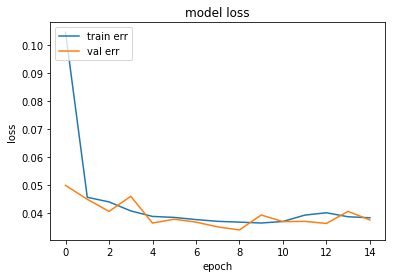

In [0]:
# 2. Plot dei risultati ottenuti.
plotResults(hist)


# Testing del modello su Random Walk unseen.

In [0]:
# 0. Funzione per aggiungere i singoli step in una lista.
def formatDataTest(data_test, capacity_vector_test):
  dataset_test = []
  
  capacity_index = 0   
  previous_capacity_index = 0
  time = 1
  count = 0
  
  for item in data_test:
    count += 1
    if(item[0][0] == 'reference discharge'):
      if(time == 1):
        time += 1
      elif(time == 2):
        time += 1
        capacity_index += 1
      else:
        if capacity_index < len(capacity_vector_test):
          capacity_index += 1
          previous_capacity_index += 1
    if(item[1][0] == 'R'):
      continue
    step_test = [item[1][0], item[2][0][-1]/(86400*30), item[3][0][-1]/3600, np.mean(item[4][0]), np.mean(item[5][0]), np.mean(item[6][0]), (capacity_vector_test[previous_capacity_index])[0], (capacity_vector_test[capacity_index])[0]]
    dataset_test.append(step_test)
      
  return dataset_test


In [0]:
# 1. Caricamento dati da file .mat.
mat_test = scio.loadmat('RW28.mat')

# 2. Estrazione dell'array contenenti gli step dei Random Walk.
data_test = mat.get('data') 
data_test = data_test[0]
data_test = data_test[0]
data_test = data_test[0]
data_test = data_test[0] #steps

# 3. Calcolo della capacità e formattazione dei dati.
capacity_vector_test = compute_capacity(data_test)

dataset_test = formatDataTest(data_test, capacity_vector_test)

# 4. Trasformazione della lista in un DataFrame.
df_test = pd.DataFrame(dataset_test, columns = ['Type', 'Time', 'RelativeTime', 'Voltage', 'Current', 'Temperature', 'PreviousCapacity', 'Capacity'])

# 5. Cancellazione colonna Type dal DataFrame.
df_test = df_test.drop(columns=["Type"])
df_test

,Time,RelativeTime,Voltage,Current,Temperature,PreviousCapacity,Capacity
0,0.004065,2.910319,4.197472,-0.530511,39.293831,2.134786,2.134786
1,0.007146,2.134939,3.683349,0.999946,41.507864,2.134786,2.134786
2,0.013790,3.283714,4.182186,-0.650307,40.191900,2.134786,2.134786
3,0.014114,0.149911,3.366122,4.460406,47.832671,2.134786,2.134786
4,0.019902,0.166667,3.992982,0.999892,39.418593,2.134786,2.134786
5,0.020596,0.166667,3.917589,0.999897,39.579906,2.134786,2.134786
6,0.021291,0.166667,3.849920,0.999887,39.619519,2.134786,2.134786
7,0.021985,0.166667,3.790586,0.999879,39.766924,2.134786,2.134786
8,0.022680,0.166667,3.740231,0.999922,39.825214,2.134786,2.134786
9,0.023374,0.166667,3.698566,0.999890,39.800588,2.134786,2.134786


In [0]:
# 6. Estrazione label.
df_test_y = df_test.iloc[:,-1]

# 7. Estrazione features.
df_test_x = df_test.iloc[:,0:6]

print(df_test_x)
print(df_test_y)

           Time  RelativeTime  ...  Temperature  PreviousCapacity
0      0.004065      2.910319  ...    39.293831          2.134786
1      0.007146      2.134939  ...    41.507864          2.134786
2      0.013790      3.283714  ...    40.191900          2.134786
3      0.014114      0.149911  ...    47.832671          2.134786
4      0.019902      0.166667  ...    39.418593          2.134786
5      0.020596      0.166667  ...    39.579906          2.134786
6      0.021291      0.166667  ...    39.619519          2.134786
7      0.021985      0.166667  ...    39.766924          2.134786
8      0.022680      0.166667  ...    39.825214          2.134786
9      0.023374      0.166667  ...    39.800588          2.134786
10     0.024068      0.166667  ...    39.755876          2.134786
11     0.024763      0.166667  ...    39.821450          2.134786
12     0.025457      0.166667  ...    39.968944          2.134786
13     0.026152      0.166667  ...    40.215005          2.134786
14     0.0

In [0]:
# 8. Esecuzione del modello su dataset di test.
predictions = model.predict(df_test_x)

In [0]:
# 9. Comparazione label con risultati predetti.
values = []

values_test = pd.DataFrame(df_test_y)
values_predictions = pd.DataFrame(predictions)

values = pd.concat([values_test, values_predictions], axis=1)

values.rename(columns = {0 : "Predicted"}, inplace=True)

values

,Capacity,Predicted
0,2.134786,2.161013
1,2.134786,2.153210
2,2.134786,2.159695
3,2.134786,2.150543
4,2.134786,2.154504
5,2.134786,2.153680
6,2.134786,2.152763
7,2.134786,2.152023
8,2.134786,2.151337
9,2.134786,2.150707


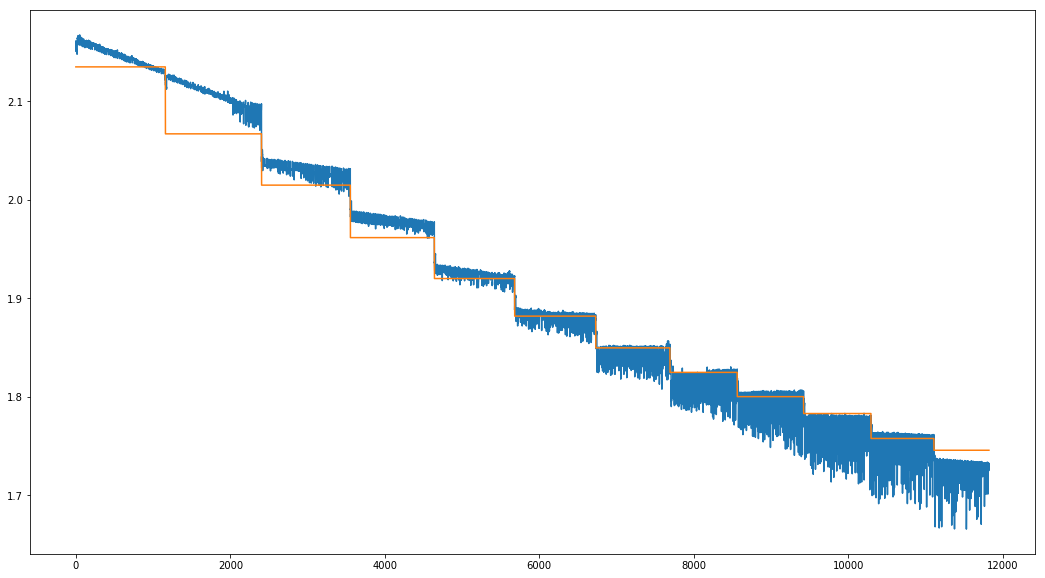

In [0]:
# 10. Plotting di predizioni e label del test set.
plt.figure(figsize=(18, 10))
plt.plot(predictions)
plt.plot(df_test_y)
plt.show()

# Salvataggio del modello per riuso successivo.

In [0]:
# 0. Import per il save del modello allenato.
import numpy
from keras.models import model_from_json

In [0]:
# 1. Salvataggio del modello.
model_name = 'model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

# 1.1. Creazione cartella di salvataggio se inesistente.
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# 1.2. Formattazione modello in formato JSON.
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

Saved trained model at /home/Dataset/saved_models/model.h5 


In [0]:
# 2. Caricamento del modello.
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# 2.1. Caricamento dei pesi nel modello.
loaded_model.load_weights("saved_models/model.h5")
print("Loaded model from disk")
 
# 2.2. Compilazione del modello caricato.
loaded_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

Loaded model from disk


In [0]:
# 3. Funzione per scaricare file dal sistema operativo di colab

from google.colab import files

files.download('saved_models/model.h5')